# Курсовой проект "Предсказание цен на недвижимость"

## Ф.И.О. студента: Воробьева А.Н.

### Подключение библиотек и основных функций

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

Функция для оценки качества прогнозов:

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:/t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:/t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize = (18, 10))
    
    plt.subplot(121)
    sns.scatterplot(x = train_pred_values, y = train_true_values)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Реальные значения')
    plt.title('Предсказание на тренировочной выборке')
    
    plt.subplot(122)
    sns.scatterplot(x = test_pred_values, y = test_true_values)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Реальные значения')
    plt.title('Предсказание на тестовой выборке')
    
    plt.show()

### Пути к директориям и файлам

In [5]:
TRAIN_DS_PATH = 'train.csv'
TEST_DS_PATH = 'test.csv'

### Загрузка данных

### *Описания полей датасета по недвижимости:*

**Id** - идентификационный номер квартиры

**DistrictId** - идентификационный номер района

**Rooms** - количество комнат

**Square** - площадь

__LifeSquare__ - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности

**Social_1, Social_2, Social_3** - социальные показатели местности

**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья

**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров

**Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DS_PATH)
train_df.tail(7)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9993,48,13,3.0,80.631333,48.899083,10.0,11,14.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,350684.628560
9994,4158,23,2.0,64.864198,NaN,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515653
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [7]:
test_df = pd.read_csv(TEST_DS_PATH)
test_df.tail(7)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4993,14562,113,2.0,46.627882,27.058739,5.0,6,5.0,1969,0.307467,B,A,30,5048,9,325.0,2,5,B
4994,6836,39,2.0,45.131282,30.780551,6.0,2,5.0,1965,0.428826,B,B,25,5011,8,730.0,0,2,B
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


Количество признаков в обучающем датасете:

In [8]:
train_df.shape[1] 

20

Проверка количество признаков в обучающем и тестовом датасетах (из обучающей отнимает признак цены)

In [9]:
train_df.shape[1]-1 == test_df.shape[1] 

True

### Приведение типов данных

просмотр, где есть пустые значения и к каким типам относятся признаки

In [10]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype(int)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)
#train_df['Ecology_2'] = train_df['Ecology_2'].astype('category')
#train_df['Ecology_3'] = train_df['Ecology_3'].astype('category')
#train_df['Social_3'] = train_df['Social_3'].astype('category')
#train_df['Helthcare_2'] = train_df['Helthcare_2'].astype('category')
#train_df['Shops_2'] = train_df['Shops_2'].astype('category')
#train_df['Shops_1'] = train_df['Shops_1'].astype('category')

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  int32  
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int32  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [13]:
train_df['Social_3'].value_counts() #Проверка категориальный признак или нет 

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
59       25
93       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

### Обзор данных

#### *Целевая переменная*

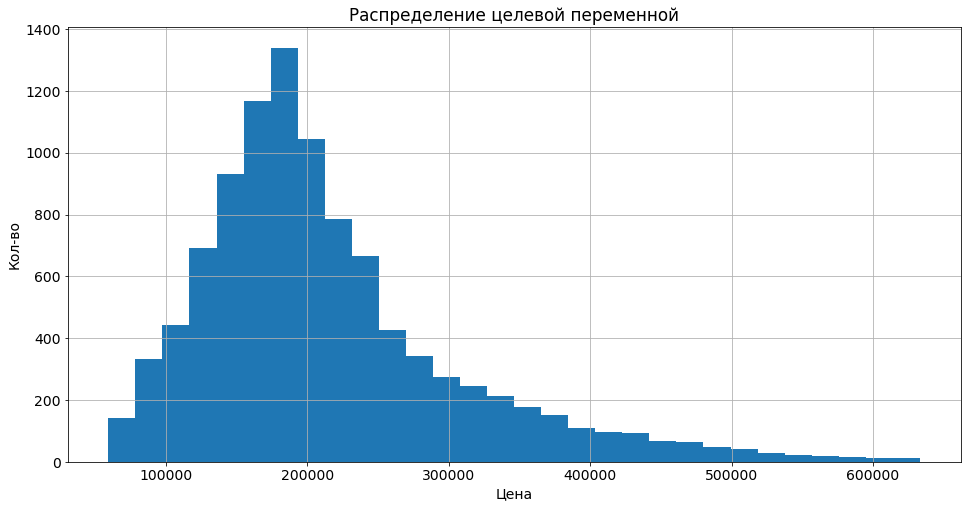

In [14]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins = 30)
plt.ylabel('Кол-во')
plt.xlabel('Цена')

plt.title('Распределение целевой переменной')

plt.show()

#### *Количественные признаки*

In [15]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обработка аномалий

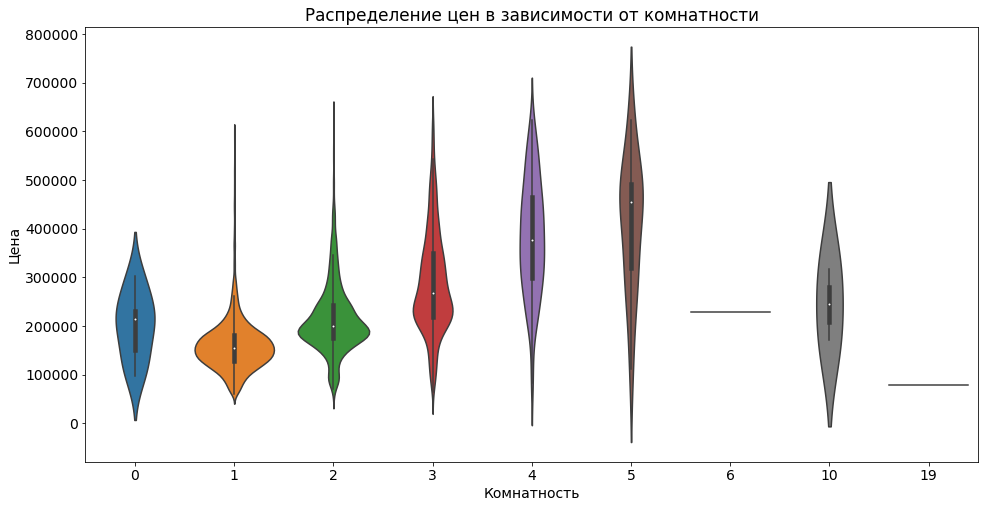

In [16]:
plt.figure(figsize=(16,8))
sns.violinplot(train_df['Rooms'], train_df['Price'])
plt.ylabel('Цена')
plt.xlabel('Комнатность')

plt.title('Распределение цен в зависимости от комнатности')
plt.show()

Из графика видны анмалии 1й квартиры большой комнатности, квартир с нулевой комнатностью, и не очень нормальное распределение у однокомнатных кварир

Аномалии квартир с нулевым кол-вом комнат

In [17]:
train_df[train_df['Rooms'] == 0] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0,138.427694,136.215499,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0,41.790881,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0,81.491446,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0,87.762616,85.125471,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


Удалении анамалии с 0 комнат и явно некорректной общей площадью 2,38 кв.м. Остальные квартрры могут быть свободной планировки

In [18]:
train_df = train_df.drop(4853) 
train_df[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0,138.427694,136.215499,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0,41.790881,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0,81.491446,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0,87.762616,85.125471,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


К остальным нулевым значениям вернемся позже

Аномалии квартир с Большим кол-вом комнат:

In [19]:
train_df[train_df['Rooms'] > 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1454,8491,1,19,42.006046,21.779288,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704


Удалении анамалии с большим кол=м комнат и при этом маленькой плащади:

In [20]:
train_df = train_df.drop(1454) 

Квартиры с анамально маленькой общей площадью:

In [21]:
train_df[train_df['Square'] < 10] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2,5.497061,67.628717,1.0,24,22,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
1316,11526,27,1,4.633498,1.969969,1.0,18,1,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6,1,2.596351,4.604943,1.0,3,25,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27,1,4.380726,40.805837,1.0,10,17,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
3413,9487,5,1,5.129222,5.549458,1.0,1,1,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4900,4504,27,3,4.390331,5.610772,1.0,8,19,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
6392,14786,1,1,1.136859,4.525736,1.0,3,1,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8030,13265,1,3,4.823679,79.767964,0.0,6,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8283,15744,34,1,1.988943,2.642219,1.0,21,4,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
9294,6782,45,1,2.954309,5.257278,1.0,3,1,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323


In [22]:
train_df = train_df.drop(212) 
#Удалении анамалии т.к. жилая площать в 13 раз превышает общую, этаж квариры превышает этажность

train_df = train_df.drop([1316, 1608, 3413, 4900, 6392, 8030, 8283, 9294, 9613]) 
#Также удаление явных аномалий с ошибками помимо площади в жилой S и этажности

In [23]:
train_df.loc[train_df['Square'] < 4.39, 'Square'] = 43.80726 #В этой анамолии скорее всего просто неверно указана запятая
train_df[train_df['Square'] == 43.80726]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3280,10527,27,1,43.80726,40.805837,1.0,10,17,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383


Поиск аномалий, где жилая площадь больше общей:

In [24]:
train_df[train_df['Square'] < train_df['LifeSquare']] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1,42.530043,43.967759,1.0,3,9,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3,104.211396,106.340403,0.0,20,0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2,61.400054,65.224603,0.0,17,22,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
123,8753,25,3,85.952306,89.803753,1.0,4,3,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
153,9870,62,1,51.831473,53.491301,1.0,5,1,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,41,30,2,59.015896,59.439082,12.0,5,5,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.142781
9889,12918,23,2,51.440463,53.134243,51.0,3,17,2017,0.005767,B,B,1,388,0,NaN,0,0,B,88150.012510
9895,2737,27,3,123.430072,125.806981,123.0,5,10,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047
9902,14001,73,1,44.098768,44.267551,1.0,7,24,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161


Так как очень много ошибок в датасете по жилой площади, то выясним у нормальных значений коэффициент разности

In [25]:
temp_ls_df = pd.DataFrame(train_df[train_df['Square'] > train_df['LifeSquare']], columns = train_df.columns) 
a = round(temp_ls_df['Square'].median() / temp_ls_df['LifeSquare'].median(), 2) 
#Создание промежуточного DF для выяснения коэффициента разности между общей и жилой площадью

In [26]:
train_df.loc[train_df['Square'] < train_df['LifeSquare'], 'LifeSquare'] = train_df.loc[train_df['Square'] < train_df['LifeSquare'], 'Square'] /a

Чтобы выявить реальные аномалии квартир с большим метражом, посмотрим насколько их метражи соответсвуют цене на графике

In [27]:
temp_big = pd.DataFrame(train_df[train_df['Square'] > 150], columns = train_df.columns) #Создание временного DF

Построим граффик рассеяния:

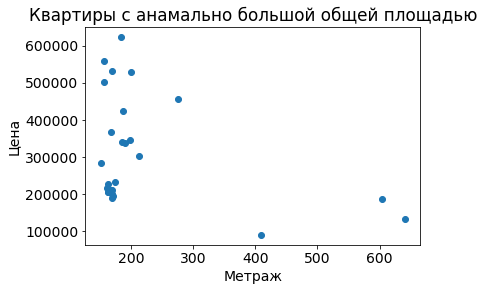

In [28]:
temp_big = plt.scatter(temp_big['Square'], temp_big['Price'])
plt.xlabel('Метраж')
plt.ylabel('Цена')
plt.title('Квартиры с анамально большой общей площадью')
plt.show() 

Из графика сильно выбиваются квартиры большого метража, но с низкой стоимостью (свыше 400 кв.м) - явно выбиваются и их лучше удалить;
   

In [29]:
train_df = train_df[train_df.Square < 400]

Поиск аномалий, где кухня больше общей площади

In [30]:
train_df[train_df['Square'] < train_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1,47.100719,46.447960,2014.0,4,1,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
5149,13703,42,1,38.071692,19.723548,73.0,9,10,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165
7088,6569,27,1,38.220258,18.716856,84.0,4,17,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
8584,14679,81,1,32.276663,19.278394,1970.0,6,1,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275


Заменим эти аномалии кухонных площадей на медиану

In [31]:
train_df.loc[train_df['Square'] < train_df['KitchenSquare'], 'KitchenSquare'] = train_df['KitchenSquare'].median()

После приведения площадей в должный вид, вернемся обратно к аномалиям по количеству комнат. С учетом того, что достаточно большой разброс в метражах с 0 кол-м комнат(скорее всего свободная планировка), то будем заменять медианой схожих по площади кварир каждую из списка

In [32]:
train_df[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0,138.427694,136.215499,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0,41.790881,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0,81.491446,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0,87.762616,85.125471,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


Заменим 0 комнат медианами схожих по площади квартир:

In [33]:
train_df.loc[(train_df['Square'] < 200 ) & (train_df['Square'] > 100) & (train_df['Rooms'] == 0) , 'Rooms'] = train_df.loc[(train_df['Square'] < 200 ) & (train_df['Square'] > 100), 'Rooms'].median()
train_df.loc[(train_df['Square'] < 250 ) & (train_df['Square'] > 200) & (train_df['Rooms'] == 0) , 'Rooms'] = train_df.loc[(train_df['Square'] < 250 ) & (train_df['Square'] > 200), 'Rooms'].median()
train_df.loc[(train_df['Square'] < 50 ) & (train_df['Square'] > 37) & (train_df['Rooms'] == 0) , 'Rooms'] = train_df.loc[(train_df['Square'] < 50 ) & (train_df['Square'] > 37), 'Rooms'].median()
train_df.loc[(train_df['Square'] < 100 ) & (train_df['Square'] > 80) & (train_df['Rooms'] == 0) , 'Rooms'] = train_df.loc[(train_df['Square'] < 100 ) & (train_df['Square'] > 80), 'Rooms'].median()

Смотрим какие еще анамалии остались в комнатах. Кроме 0 комнат, посмотрим :

In [34]:
train_df['Rooms'].value_counts() 

2     3878
1     3700
3     2236
4      150
5       18
10       2
6        1
Name: Rooms, dtype: int64

Рассмотрим детально квартиры с 10 комнатами:

In [35]:
train_df[train_df['Rooms'] == 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10,59.056975,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
8849,14865,9,10,60.871266,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


Здесь также явные аномалии, которые мы заменинм на медианы схожих по площади кварир:

In [36]:
train_df.loc[train_df['Rooms'] == 10 , 'Rooms'] = train_df.loc[(train_df['Square'] < 65 ) & (train_df['Square'] > 55), 'Rooms'].median()

Обработка аномалий, где этаж квартиры выше этажности самого дома:

In [37]:
train_df[train_df['HouseFloor'] < train_df['Floor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2,80.312926,NaN,0.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
14,10953,27,1,53.769097,52.408027,1.0,5,4,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
16,2119,27,2,49.360648,31.993964,5.0,6,5,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.381287
21,11935,27,2,64.711835,NaN,1.0,15,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
23,6641,54,3,118.907612,NaN,0.0,2,0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3,64.074977,47.633428,6.0,11,9,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.880156
9985,16159,27,1,38.968338,NaN,1.0,10,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.569405
9989,4145,96,3,90.055233,47.860231,11.0,26,24,2005,0.041116,B,B,53,14892,4,NaN,1,4,B,441108.911237
9991,11553,3,3,101.622794,51.628780,12.0,18,17,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.501504


На данных с таким количеством ошибок конечно очень проблематично что-либо спрогнозировать.. Меням нулевую этажность на медиану

In [38]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

Обрабатываем ту этажность, что ниже этажа квартиры:

In [39]:
temp_floor = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[temp_floor, 'Floor'] = train_df.loc[temp_floor, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Устранение аномалий в годах постройки:

In [40]:
train_df[(train_df['HouseYear'] > 2022) | (train_df['HouseYear'] < 1900)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1,37.265070,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2,44.791836,28.360393,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [41]:
train_df.loc[train_df['HouseYear'] > 2022, 'HouseYear'] = 2020

### Обработка пропусков

In [42]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2112
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4789
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Заполним пропуски в жилой площади и показателе местности медианой... Хотя с учтом количества ошибок в жилой и пропусков в признаке местности, ориентировать на эти данные вообще не стоит

In [43]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

Уберем образовавшиеся аномалии, где жилая площадь превышает общую также по ранее вычисленному коэффициенту

In [44]:
train_df.loc[train_df['Square'] < train_df['LifeSquare'], 'LifeSquare'] = train_df.loc[train_df['Square'] < train_df['LifeSquare'], 'Square'] /a


In [45]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Доработка аномалий

In [46]:
train_df.shape

(9985, 20)

Удаляем все, что осталось за пределами нормального распределения

In [47]:
train_df = train_df[(train_df['Square'] < train_df['Square'].quantile(.975)) |
                    (train_df['Square'] < train_df['Square'].quantile(.025))]

train_df = train_df[(train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.975)) |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.025))]

train_df = train_df[(train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.975)) |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.025))]

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
             
train_df.shape

(9086, 20)

### Постраение новых признаков

Посмотрим корреляцию признаков между собой

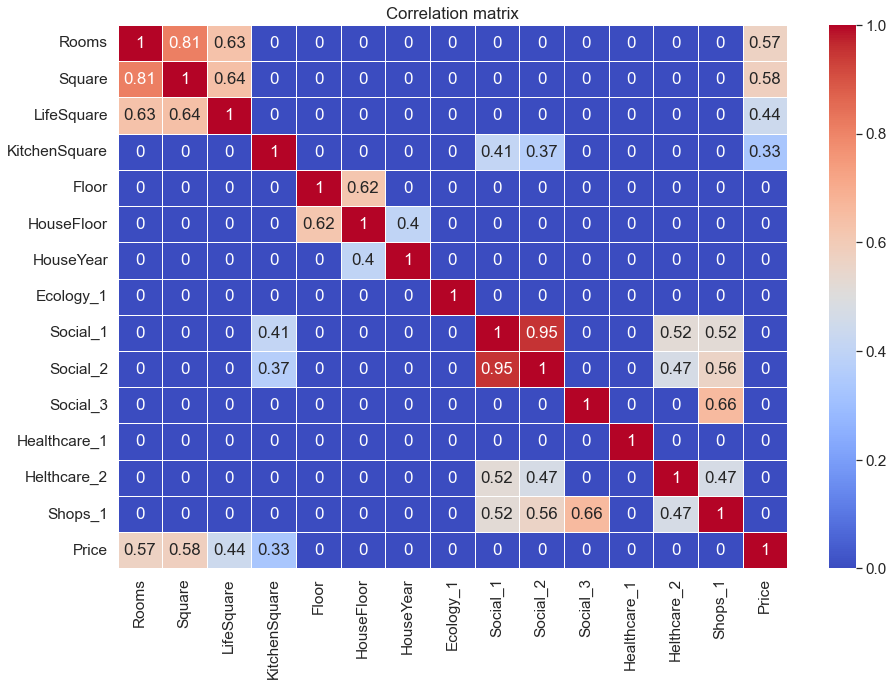

In [48]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Мы видим, что в целом корреляции никакой, за исключение корреляции между общей площадбю и жилой, площадбю и комнатностью, и есть немного между комнатностью и цено, и ценой и площадью

Добавление dummies признаков из категориальных:

In [49]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

Создание доп. признака размера района:

In [50]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
.rename(columns = {'index': 'DistrictId', 'DistrictId': 'DistrictSize'})

In [51]:
train_df = train_df.merge(district_size, on = 'DistrictId', how = 'left' )
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,5,900.0,0,11,B,184966.930730,1,1,1,21
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,80
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,0,229.0,1,3,B,220925.908524,1,1,1,157
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,158
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,96


Создание доп. категориального признака размерности района:

In [52]:
(train_df['DistrictSize'] > 100).value_counts()

False    4929
True     4157
Name: DistrictSize, dtype: int64

In [53]:
train_df['LargeDistrict'] = (train_df['DistrictSize'] > 100).astype(int)

Создание доп. категории средней цены в зависимости от комнатности и района

In [54]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index = False).agg({'Price': 'median'}).rename(columns = {'Price': 'MedPriceByDistrict'})

In [55]:
train_df = train_df.merge(med_price_by_district, on = ['DistrictId', 'Rooms'], how = 'left' )
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,0,11,B,184966.930730,1,1,1,21,0,207786.135836
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,16,B,300009.450063,1,1,1,80,0,294023.343470
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,1,3,B,220925.908524,1,1,1,157,1,261085.981996
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,0,5,B,175616.227217,1,1,1,158,1,169246.115943
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,2,4,B,150226.531644,1,1,1,96,0,158539.052715


Разобьем условные категории площадь и добавим новые признак категории медианной цены такого диапазона площадей

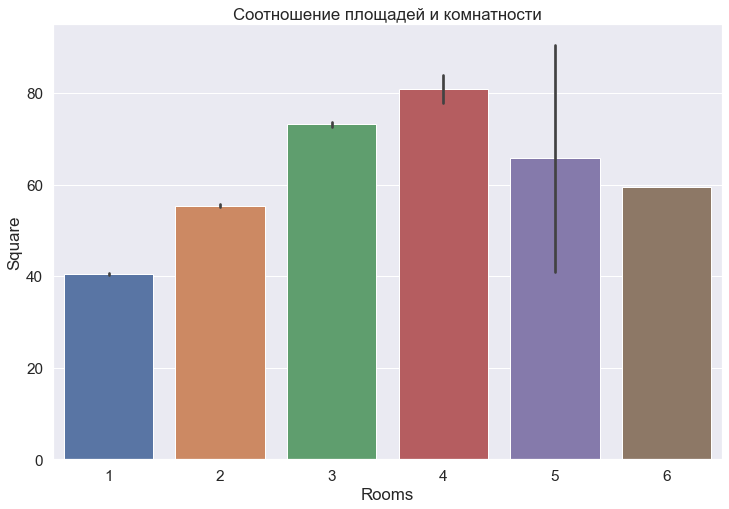

In [56]:
plt.figure(figsize=(12,8))    
plt.title('Соотношение площадей и комнатности')
sns.barplot(train_df['Rooms'], train_df['Square'])
    
plt.show()

In [57]:
train_df['PricePerMetr'] = pd.Series()

Создадим массив значений средних цен, на которые сможе ссылаться и тестовый датасет

In [58]:
Price_1 = train_df.loc[train_df['Square'] < 40, 'Price'].median()
Price_2 = train_df.loc[(train_df['Square'] >= 40) & (train_df['Square'] < 57), 'Price'].median()
Price_3 = train_df.loc[(train_df['Square'] >= 57) & (train_df['Square'] < 77), 'Price'].median()
Price_4 = train_df.loc[train_df['Square'] >= 77, 'Price'].median()

In [59]:
train_df.loc[train_df['Square'] < 40 , 'PricePerMetr'] = Price_1 
train_df.loc[(train_df['Square'] >= 40) & (train_df['Square'] < 57), 'PricePerMetr'] = Price_2 
train_df.loc[(train_df['Square'] >= 57) & (train_df['Square'] < 77), 'PricePerMetr'] = Price_3
train_df.loc[train_df['Square'] >= 77, 'PricePerMetr'] = Price_4 

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict,PricePerMetr
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,11,B,184966.930730,1,1,1,21,0,207786.135836,181080.911759
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,16,B,300009.450063,1,1,1,80,0,294023.343470,229916.692769
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,3,B,220925.908524,1,1,1,157,1,261085.981996,181080.911759
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,5,B,175616.227217,1,1,1,158,1,169246.115943,181080.911759
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,4,B,150226.531644,1,1,1,96,0,158539.052715,158700.712031


Добавление доп. признака средней площади квартир по их комнатности

In [60]:
train_df['MedSquareByRooms'] = pd.Series()

In [61]:
train_df.loc[train_df['Rooms'] == 1, 'MedSquareByRooms'] = train_df.loc[train_df['Rooms'] == 1, 'Square'].median()
train_df.loc[train_df['Rooms'] == 2, 'MedSquareByRooms'] = train_df.loc[train_df['Rooms'] == 2, 'Square'].median()
train_df.loc[train_df['Rooms'] == 3, 'MedSquareByRooms'] = train_df.loc[train_df['Rooms'] == 3, 'Square'].median()
train_df.loc[train_df['Rooms'] == 4, 'MedSquareByRooms'] = train_df.loc[train_df['Rooms'] == 4, 'Square'].median()
train_df.loc[train_df['Rooms'] == 5, 'MedSquareByRooms'] = train_df.loc[train_df['Rooms'] == 5, 'Square'].median()
train_df.loc[train_df['Rooms'] == 6, 'MedSquareByRooms'] = train_df.loc[train_df['Rooms'] == 6, 'Square'].median()
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict,PricePerMetr,MedSquareByRooms
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,B,184966.930730,1,1,1,21,0,207786.135836,181080.911759,55.106163
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,B,300009.450063,1,1,1,80,0,294023.343470,229916.692769,75.576821
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,B,220925.908524,1,1,1,157,1,261085.981996,181080.911759,55.106163
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,B,175616.227217,1,1,1,158,1,169246.115943,181080.911759,55.106163
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,B,150226.531644,1,1,1,96,0,158539.052715,158700.712031,40.257605


Разобьем этажи на категории

In [62]:
train_df['Floor'].value_counts()

4     903
3     900
5     869
1     776
2     633
7     625
8     611
6     587
9     564
10    405
12    394
11    356
13    295
14    264
16    234
15    214
17    184
18     52
19     46
20     43
21     39
22     37
24     23
23     14
25     13
32      2
42      1
31      1
33      1
Name: Floor, dtype: int64

In [63]:
train_df['CatFloor'] = pd.Series()

In [64]:
train_df.loc[train_df['Floor'] <= 3 , 'CatFloor'] = 'low_floor'
train_df.loc[(train_df['Floor'] > 3) & (train_df['Floor'] <= 17), 'CatFloor'] = 'middle_floor'
train_df.loc[train_df['Floor'] > 17, 'CatFloor'] = 'high_floor'
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict,PricePerMetr,MedSquareByRooms,CatFloor
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,184966.930730,1,1,1,21,0,207786.135836,181080.911759,55.106163,middle_floor
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,300009.450063,1,1,1,80,0,294023.343470,229916.692769,75.576821,middle_floor
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,220925.908524,1,1,1,157,1,261085.981996,181080.911759,55.106163,middle_floor
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,175616.227217,1,1,1,158,1,169246.115943,181080.911759,55.106163,middle_floor
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,150226.531644,1,1,1,96,0,158539.052715,158700.712031,40.257605,middle_floor


Поменяем тип данного столбца на категориальный

In [65]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9086 entries, 0 to 9085
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  9086 non-null   object 
 1   DistrictId          9086 non-null   object 
 2   Rooms               9086 non-null   int32  
 3   Square              9086 non-null   float64
 4   LifeSquare          9086 non-null   float64
 5   KitchenSquare       9086 non-null   float64
 6   Floor               9086 non-null   int64  
 7   HouseFloor          9086 non-null   int32  
 8   HouseYear           9086 non-null   int64  
 9   Ecology_1           9086 non-null   float64
 10  Ecology_2           9086 non-null   object 
 11  Ecology_3           9086 non-null   object 
 12  Social_1            9086 non-null   int64  
 13  Social_2            9086 non-null   int64  
 14  Social_3            9086 non-null   int64  
 15  Healthcare_1        9086 non-null   float64
 16  Helthc

In [66]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['CatFloor'])], axis=1)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict,PricePerMetr,MedSquareByRooms,CatFloor,high_floor,low_floor,middle_floor
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,1,21,0,207786.135836,181080.911759,55.106163,middle_floor,0,0,1
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,80,0,294023.343470,229916.692769,75.576821,middle_floor,0,0,1
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,1,157,1,261085.981996,181080.911759,55.106163,middle_floor,0,0,1
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,1,158,1,169246.115943,181080.911759,55.106163,middle_floor,0,0,1
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,1,96,0,158539.052715,158700.712031,40.257605,middle_floor,0,0,1


### Приведение тестовой выборки в соответствие с типами и пр

In [67]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [68]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
test_df['Rooms'] = test_df['Rooms'].astype(int)
#test_df['HouseFloor'] = test_df['HouseFloor'].astype(int)
#test_df['Ecology_2'] = test_df['Ecology_2'].astype('category')
#test_df['Ecology_3'] = test_df['Ecology_3'].astype('category')
#test_df['Social_3'] = test_df['Social_3'].astype('category')
#test_df['Helthcare_2'] = test_df['Helthcare_2'].astype('category')
#test_df['Shops_2'] = test_df['Shops_2'].astype('category')
#test_df['Shops_1'] = test_df['Shops_1'].astype('category')

In [69]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   int32  
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [70]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Устраняем аномалии слишком маленьких метражей

In [71]:
test_df[test_df['Square'] < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
66,9011,53,1,1.378543,1.353573,1.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
608,16401,30,1,2.645046,4.338755,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
837,2138,27,1,5.647458,1.501582,1.0,1,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
1165,10120,6,1,5.100672,3.861780,1.0,3,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4490,1165,27,1,2.372101,1.899119,1.0,2,17.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
4540,7855,6,1,4.967143,2.968086,1.0,3,1.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B
4713,170,6,2,2.900586,61.468563,1.0,18,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
4902,1420,45,1,1.975769,2.900371,1.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B


In [72]:
test_df.loc[(test_df['Square'] < 10 ) & (test_df['Rooms'] == 1), 'Square'] = test_df.loc[(test_df['Square'] > 10 ) & (test_df['Rooms'] == 1), 'Square'].median()
test_df.loc[(test_df['Square'] < 10 ) & (test_df['Rooms'] == 2), 'Square'] = test_df.loc[(test_df['Square'] > 20 ) & (test_df['Rooms'] == 2), 'Square'].median()

Обработка аномалий жилой площади:

In [73]:
test_df.loc[test_df['Square'] < test_df['LifeSquare'], 'LifeSquare'] = test_df.loc[test_df['Square'] < test_df['LifeSquare'], 'Square'] /a

Заполнение пропусков в жилой площади медианой:

In [74]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['LifeSquare'].median()

Повторно устраняем аномалии жилой площади:

In [75]:
test_df.loc[test_df['Square'] < test_df['LifeSquare'], 'LifeSquare'] = test_df.loc[test_df['Square'] < test_df['LifeSquare'], 'Square'] /a

Аномалии квартир с нулевым кол-м комнат:

In [76]:
test_df[test_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [77]:
test_df.loc[(test_df['Square'] < 150 ) & (test_df['Square'] > 100) & (test_df['Rooms'] == 0) , 'Rooms'] = test_df.loc[(test_df['Square'] < 150 ) & (test_df['Square'] > 100), 'Rooms'].median()
test_df.loc[(test_df['Square'] < 80 ) & (test_df['Square'] > 50) & (test_df['Rooms'] == 0) , 'Rooms'] = test_df.loc[(test_df['Square'] < 80 ) & (test_df['Square'] > 50), 'Rooms'].median()

Аномалии с большим кол-м комнат:

In [78]:
test_df[test_df['Rooms'] > 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3398,1435,111,17,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [79]:
test_df.loc[test_df['Rooms'] == 17, 'Rooms'] = test_df.loc[(test_df['Square'] < 60 ) & (test_df['Square'] > 50), 'Rooms'].median()

In [80]:
test_df['Rooms'] = test_df['Rooms'].astype(int)

Аномалии больших метражей:

In [81]:
test_df[test_df['Square'] > 150]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1264,13589,27,3,173.974480,76.289475,9.0,3,3.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
1499,7769,124,4,189.679576,114.708673,4.0,19,40.0,2013,0.174739,B,B,17,3379,9,100.0,0,3,B
2039,3357,27,3,170.476326,75.973612,8.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
2557,16053,17,4,168.729035,106.790528,0.0,4,0.0,2013,0.093443,B,B,23,4635,5,3300.0,2,4,B
3217,4058,27,6,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3253,12316,183,5,157.976101,101.040485,12.0,7,8.0,1908,0.246624,B,B,14,2940,45,NaN,3,6,B
3909,1397,76,3,221.138768,118.055342,4.0,32,48.0,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
4384,14498,23,1,163.325901,32.280713,1.0,3,1.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B


In [82]:
test_df.loc[(test_df['Square'] > 160) & (test_df['Rooms'] == 1) , 'Rooms'] = test_df.loc[(test_df['Square'] > 150 ) & (test_df['Square'] < 200), 'Rooms'].median()
test_df[test_df['Square'] > 150]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1264,13589,27,3.0,173.974480,76.289475,9.0,3,3.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
1499,7769,124,4.0,189.679576,114.708673,4.0,19,40.0,2013,0.174739,B,B,17,3379,9,100.0,0,3,B
2039,3357,27,3.0,170.476326,75.973612,8.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
2557,16053,17,4.0,168.729035,106.790528,0.0,4,0.0,2013,0.093443,B,B,23,4635,5,3300.0,2,4,B
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3253,12316,183,5.0,157.976101,101.040485,12.0,7,8.0,1908,0.246624,B,B,14,2940,45,NaN,3,6,B
3909,1397,76,3.0,221.138768,118.055342,4.0,32,48.0,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
4384,14498,23,3.5,163.325901,32.280713,1.0,3,1.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B


Аномалии площади кухни

In [83]:
test_df.loc[test_df['Square'] < test_df['KitchenSquare'], 'KitchenSquare'] = test_df['KitchenSquare'].median()

Обработка анамолий этажности дома

In [84]:
test_df[test_df['HouseFloor'] < test_df['Floor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2.0,69.263183,32.280713,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
10,15975,61,3.0,64.543658,42.651541,7.0,10,9.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B
14,5214,27,1.0,37.555197,32.280713,1.0,5,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
22,12694,27,3.0,83.670032,46.358356,0.0,8,0.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A
24,8968,27,2.0,69.849239,32.280713,0.0,3,0.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1.0,45.542940,32.280713,0.0,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B
4989,2591,39,2.0,44.203592,30.191691,6.0,10,9.0,1972,0.428826,B,B,25,5011,8,730.0,0,2,B
4993,14562,113,2.0,46.627882,27.058739,5.0,6,5.0,1969,0.307467,B,A,30,5048,9,325.0,2,5,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B


In [85]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [86]:
temp_floor_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[temp_floor_test, 'Floor'] = test_df.loc[temp_floor_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Обработка пропусков в признаке здоровья:

In [87]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

#### Добавление признаков в тестовый датасет:

In [88]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [89]:
test_df = test_df.merge(district_size, on = 'DistrictId', how = 'left' )
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,900.0,0,0,B,1,1,1,158.0
1,15856,74,2.0,69.263183,32.280713,1.0,1,1.0,1977,0.075779,...,1437,3,900.0,0,2,B,1,1,1,92.0
2,5480,190,1.0,13.597819,8.606214,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,B,1,1,1,7.0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,900.0,3,3,B,1,1,1,95.0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,900.0,0,0,A,1,1,0,736.0


In [90]:
test_df['LargeDistrict'] = (test_df['DistrictSize'] > 100).astype(int)

In [91]:
test_df = test_df.merge(med_price_by_district, on = ['DistrictId', 'Rooms'], how = 'left' )
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,900.0,0,0,B,1,1,1,158.0,1,169246.115943
1,15856,74,2.0,69.263183,32.280713,1.0,1,1.0,1977,0.075779,...,900.0,0,2,B,1,1,1,92.0,0,242298.108379
2,5480,190,1.0,13.597819,8.606214,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,B,1,1,1,7.0,0,NaN
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,900.0,3,3,B,1,1,1,95.0,0,221547.417041
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,900.0,0,0,A,1,1,0,736.0,1,117460.696558


In [92]:
test_df['PricePerMetr'] = pd.Series()

In [93]:
test_df.loc[test_df['Square'] < 40 , 'PricePerMetr'] = Price_1
test_df.loc[(test_df['Square'] >= 40) & (test_df['Square'] < 57), 'PricePerMetr'] = Price_2
test_df.loc[(test_df['Square'] >= 57) & (test_df['Square'] < 77), 'PricePerMetr'] = Price_3
test_df.loc[test_df['Square'] >= 77, 'PricePerMetr'] = Price_4

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict,PricePerMetr,MedSquareByRooms,CatFloor,high_floor,low_floor,middle_floor
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,1,21,0,207786.135836,181080.911759,55.106163,middle_floor,0,0,1
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,80,0,294023.343470,229916.692769,75.576821,middle_floor,0,0,1
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,1,157,1,261085.981996,181080.911759,55.106163,middle_floor,0,0,1
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,1,158,1,169246.115943,181080.911759,55.106163,middle_floor,0,0,1
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,1,96,0,158539.052715,158700.712031,40.257605,middle_floor,0,0,1


In [94]:
test_df['MedSquareByRooms'] = pd.Series()

In [95]:
test_df.loc[test_df['Rooms'] == 1, 'MedSquareByRooms'] = test_df.loc[test_df['Rooms'] == 1, 'Square'].median()
test_df.loc[test_df['Rooms'] == 2, 'MedSquareByRooms'] = test_df.loc[test_df['Rooms'] == 2, 'Square'].median()
test_df.loc[test_df['Rooms'] == 3, 'MedSquareByRooms'] = test_df.loc[test_df['Rooms'] == 3, 'Square'].median()
test_df.loc[test_df['Rooms'] == 4, 'MedSquareByRooms'] = test_df.loc[test_df['Rooms'] == 4, 'Square'].median()
test_df.loc[test_df['Rooms'] == 5, 'MedSquareByRooms'] = test_df.loc[test_df['Rooms'] == 5, 'Square'].median()
test_df.loc[test_df['Rooms'] == 6, 'MedSquareByRooms'] = test_df.loc[test_df['Rooms'] == 6, 'Square'].median()
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict,PricePerMetr,MedSquareByRooms
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,0,B,1,1,1,158.0,1,169246.115943,181080.911759,55.829730
1,15856,74,2.0,69.263183,32.280713,1.0,1,1.0,1977,0.075779,...,2,B,1,1,1,92.0,0,242298.108379,229916.692769,55.829730
2,5480,190,1.0,13.597819,8.606214,12.0,2,5.0,1909,0.000000,...,5,B,1,1,1,7.0,0,NaN,158700.712031,40.170775
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,B,1,1,1,95.0,0,221547.417041,229916.692769,55.829730
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,0,A,1,1,0,736.0,1,117460.696558,181080.911759,40.170775


In [96]:
test_df['CatFloor'] = pd.Series()

In [97]:
test_df.loc[test_df['Floor'] <= 3 , 'CatFloor'] = 'low_floor'
test_df.loc[(test_df['Floor'] > 3) & (test_df['Floor'] <= 17), 'CatFloor'] = 'middle_floor'
test_df.loc[test_df['Floor'] > 17, 'CatFloor'] = 'high_floor'
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict,PricePerMetr,MedSquareByRooms,CatFloor
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,B,1,1,1,158.0,1,169246.115943,181080.911759,55.829730,middle_floor
1,15856,74,2.0,69.263183,32.280713,1.0,1,1.0,1977,0.075779,...,B,1,1,1,92.0,0,242298.108379,229916.692769,55.829730,low_floor
2,5480,190,1.0,13.597819,8.606214,12.0,2,5.0,1909,0.000000,...,B,1,1,1,7.0,0,NaN,158700.712031,40.170775,low_floor
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,B,1,1,1,95.0,0,221547.417041,229916.692769,55.829730,high_floor
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,A,1,1,0,736.0,1,117460.696558,181080.911759,40.170775,middle_floor


In [98]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['CatFloor'])], axis=1)

In [99]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   object 
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

Видим, что комнаты по прежнему не хотят становится целочисленным, и есть пропуски в новых признаках. Поэтому исправим это:

In [100]:
test_df.loc[test_df['DistrictSize'].isnull(), 'DistrictSize'] = test_df['DistrictSize'].median()
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_df['MedPriceByDistrict'].median()
test_df.loc[test_df['MedSquareByRooms'].isnull(), 'MedSquareByRooms'] = test_df['MedSquareByRooms'].median()
test_df['Rooms'] = test_df['Rooms'].astype(int)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   object 
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   int32  
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

### Отбор признаков

In [101]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'LargeDistrict',
 'MedPriceByDistrict',
 'PricePerMetr',
 'MedSquareByRooms',
 'CatFloor',
 'high_floor',
 'low_floor',
 'middle_floor']

В основные признаки не вошли 'DistrictId'(Т.к. сам id ничего не говорит, а 'DistrictSize' говорит о густонаселенности),'Floor' (потому что есть отдельный категориальный признак 'CatFloor'), 'HouseFloor' (потому что в этом признаке много ошибок было)

In [102]:
feature_names = ['Rooms','Square', 'LifeSquare', 'KitchenSquare', 'HouseYear',
 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_bin', 
'Ecology_3_bin', 'Shops_2_bin']
new_feature_names = ['DistrictSize', 'LargeDistrict', 'MedPriceByDistrict','MedSquareByRooms', 'PricePerMetr',  'high_floor', 'low_floor', 'middle_floor']
target_name = ['Price']

### Разбиение на тест и трейн

In [103]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 21)

In [105]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=50, # глубина дерева  
                                 min_samples_leaf=4, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=150  # кол-во деревьев
                                 )

In [106]:
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

In [107]:
y_train_preds

array([179109.82750439, 381434.03662486, 159905.97404959, ...,
       193683.21002539, 230065.64110984, 201470.6982892 ])

In [108]:
print("Train R2:/t" + str(round(r2(y_train, y_train_preds), 3)))
print("Test R2:/t" + str(round(r2(y_test, y_test_preds), 3)))

Train R2:/t0.898
Test R2:/t0.733


Еще на попроповала линейную регрессию. Она оказалась немного хуже. 
Возникла проблема, которую мне так и не удалось решить... Не работает функция evaluate_preds, которую дала нам преподаватель. Ни строятся никакие графики на этих данных. Возможно проблема в индексах... Но на занятиях мы делали все тоже самое и у преподавателя работало.. а у меня нет. Причем я удаляла разные признаки.. Но ошибка не исчезает. 

In [109]:
#evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [110]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
17,MedPriceByDistrict,0.723439
1,Square,0.087427
3,KitchenSquare,0.030669
4,HouseYear,0.030364
2,LifeSquare,0.020479
8,Social_3,0.019221
15,DistrictSize,0.016465
7,Social_2,0.015005
5,Ecology_1,0.013242
6,Social_1,0.012821


In [111]:
Total_test = test_df[feature_names + new_feature_names]
Total_test.head()

,Rooms,Square,LifeSquare,KitchenSquare,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,...,Ecology_3_bin,Shops_2_bin,DistrictSize,LargeDistrict,MedPriceByDistrict,MedSquareByRooms,PricePerMetr,high_floor,low_floor,middle_floor
0,2,49.882643,33.432782,6.0,1972,0.310199,11,2748,1,900.0,...,1,1,158.0,1,169246.115943,55.829730,181080.911759,0,0,1
1,2,69.263183,32.280713,1.0,1977,0.075779,6,1437,3,900.0,...,1,1,92.0,0,242298.108379,55.829730,229916.692769,0,1,0
2,1,13.597819,8.606214,12.0,1909,0.000000,30,7538,87,4702.0,...,1,1,7.0,0,193262.229890,40.170775,158700.712031,0,1,0
3,2,73.046609,51.940842,9.0,2007,0.101872,23,4583,3,900.0,...,1,1,95.0,0,221547.417041,55.829730,229916.692769,1,0,0
4,1,47.527111,43.387569,1.0,2017,0.072158,2,629,1,900.0,...,1,0,736.0,1,117460.696558,40.170775,181080.911759,0,0,1


Указываем путь для сохранения полученных данных:

In [112]:
TEST_DATASET_EXT_PATH = 'AVorobeva_predictions.csv'

In [113]:
price = rf_model.predict(Total_test)
pd.DataFrame({ 'Id': test_df['Id'], 'Price': price}).to_csv(TEST_DATASET_EXT_PATH, index=False)